# Importing/Installing Libraries

In [ ]:
!pip install ucimlrepo
!pip install wandb -q
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.7 MB/s eta 0:00:00


In [543]:
# core
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# metrics
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score,f1_score
from sklearn.metrics import confusion_matrix as cm

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# utils
from sklearn.utils import resample
from ucimlrepo import fetch_ucirepo
import re
import wandb
import joblib

In [ ]:
wandb.login(relogin=True)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ali-rahimi-ai-pro (mygita) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Loading Data

In [ ]:
data = fetch_ucirepo(id=296)

features = data.data.features
targets = data.data.targets
dataframe = pd.concat([features, targets], axis=1)

/usr/local/lib/python3.11/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


# EDA

### Data Overview

In [ ]:
def get_info(data, columns=None):
    variable_name = []
    total_value = []
    total_missing_value = []
    missing_value_rate = []
    unique_value_list = []
    total_unique_value = []
    data_type = []

    # If no columns are specified, use all columns
    if columns is None:
        columns = data.columns

    for col in columns:
        variable_name.append(col)
        data_type.append(data[col].dtype)
        total_value.append(data[col].shape[0])
        total_missing_value.append(data[col].isnull().sum())
        missing_value_rate.append(round(data[col].isnull().sum()/data[col].shape[0], 4))
        unique_value_list.append(data[col].unique())
        total_unique_value.append(len(data[col].unique()))

    missing_data = pd.DataFrame({
        "Variable": variable_name,
        "#_Total_Value": total_value,
        "#_Total_Missing_Value": total_missing_value,
        "%_Missing_Value_Rate": missing_value_rate,
        "Data_Type": data_type,
        "Unique_Value": unique_value_list,
        "Total_Unique_Value": total_unique_value
    })

    missing_data = missing_data.set_index("Variable")
    return missing_data.sort_values("#_Total_Missing_Value", ascending=False)


In [ ]:
data_info = get_info(dataframe)
data_info

,#_Total_Value,#_Total_Missing_Value,%_Missing_Value_Rate,Data_Type,Unique_Value,Total_Unique_Value
Variable,,,,,,
weight,101766,98569,0.9686,object,"[nan, [75-100), [50-75), [0-25), [100-125), [2...",10
max_glu_serum,101766,96420,0.9475,object,"[nan, >300, Norm, >200]",4
A1Cresult,101766,84748,0.8328,object,"[nan, >7, >8, Norm]",4
medical_specialty,101766,49949,0.4908,object,"[Pediatrics-Endocrinology, nan, InternalMedici...",73
payer_code,101766,40256,0.3956,object,"[nan, MC, MD, HM, UN, BC, SP, CP, SI, DM, CM, ...",18
race,101766,2273,0.0223,object,"[Caucasian, AfricanAmerican, nan, Other, Asian...",6
diag_3,101766,1423,0.0140,object,"[nan, 255, V27, 403, 250, V45, 38, 486, 996, 1...",790
diag_2,101766,358,0.0035,object,"[nan, 250.01, 250, 250.43, 157, 411, 492, 427,...",749
diag_1,101766,21,0.0002,object,"[250.83, 276, 648, 8, 197, 414, 428, 398, 434,...",717


In [ ]:
def distribution_proportion(df, column_name, target_name):
    plt.figure(figsize=(16, 4))
    sns.countplot(data=df, x=column_name, hue=target_name, palette='Spectral', dodge=True)
    plt.title(f'Distribution of {column_name} by {target_name} status')
    plt.show()

    print()
    proportion_table = df.groupby(column_name)[target_name].value_counts(normalize=True).unstack()
    total_counts = df.groupby(column_name).size()
    proportion_table['Total Count'] = total_counts

    print(proportion_table)

In [ ]:
def display_all(df):
    with pd.option_context("display.max_row", 50, "display.max_columns", 50):
        display(df)
display_all(dataframe.head(5))

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [ ]:
dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
admission_type_id,101766.0,2.024006,1.445403,1.0,1.0,1.0,3.0,8.0
discharge_disposition_id,101766.0,3.715642,5.280166,1.0,1.0,1.0,4.0,28.0
admission_source_id,101766.0,5.754437,4.064081,1.0,1.0,7.0,7.0,25.0
time_in_hospital,101766.0,4.395987,2.985108,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,101766.0,43.095641,19.674362,1.0,31.0,44.0,57.0,132.0
num_procedures,101766.0,1.339730,1.705807,0.0,0.0,1.0,2.0,6.0
num_medications,101766.0,16.021844,8.127566,1.0,10.0,15.0,20.0,81.0
number_outpatient,101766.0,0.369357,1.267265,0.0,0.0,0.0,0.0,42.0
number_emergency,101766.0,0.197836,0.930472,0.0,0.0,0.0,0.0,76.0
number_inpatient,101766.0,0.635566,1.262863,0.0,0.0,0.0,1.0,21.0


In [ ]:
dataframe.duplicated().sum()

0



---


### Feature Description:

1 - race (5 unique): Caucasian, Asian, African American, Hispanic, and other. (2273 missing)

2 - gender (3 unique): male, female, and unknown/invalid. (0 missing)

3 - age, grouped in 10-year intervals (10 unique): [0-10), [10-20), [20-30), ... , [90-100). (0 missing)

4 - weight, grouped in 25-pound intervals (9 unique): [0-25), [25-50), ... , [175-200), >200. (98569 missing)

5 - admission_type_id (8 unique): integer corresponding to one of admission types: 1-Emergency, 2-Urgent, 3-Elective, 4-Newborn, 5-Not Available, 6-NULL, 7-Trauma Center, 8-Not Mapped (0 missing)

6 - discharge_disposition_id (26 unique): integer corresponding to one of discharge_disposition types. (0 missing)

7 - admission_source_id (17 unique): integer corresponding to one of admission source types. (0 missing)

8 - time_in_hospital (14 unique): number of days between admission and discharge (0 missing)

9 - payer_code (17 unique): integer corresponding to the expected primary source of payment (40256 missing)

10 - medical_specialty (72 unique): integer identifier of a specialty of the admitting physician (49949 missing)

11-16 - number of lab procedures, procedures, medications, outpatient visits, emergency visits and inpatient visits (0 missing)

17 - diag_1: the primary diagnosis, a ICD9 code corresponding to a disease (21 missing)

18 - diag_2: the secondary diagnosis (358 missing)

19 - diag_3: the additional secondary diagnosis (1423 missing)

20 - number_diagnoses: number of all diagnoses (0 missing)

21 - max_glu_serum: indicates the range of the result or if the test was not taken. Values: ">200", ">300", "normal," (96420 missing means not measured)

22 - A1Cresult: indicates the range of the result or if the test was not taken. Values: ">8" if the result was greater than 8%, ">7" if the result was greater than 7% but less than 8%, "normal" if the result was less than 7%. (84748 missing means not measured)

23-45 - medications: "No", "Up", "Down", "Steady" (0 missing)

46 - change: indicates if there was a change in diabetic medications (either dosage or generic name). Values: "Ch" and "No" (0 missing)

47 - diabetesMed: indicates if there was any diabetic medication prescribed. Values: "Yes" and "No" (0 missing)

### Target Description
1 - readmitted: days to inpatient readmission. values: "<30" if the patient was readmitted in less than 30 days, ">30" if the patient was readmitted in more than 30 days, and "No" for no record of readmission.
I converted >30 values to 0, because we want to predict if the patient readmits in 30 days after discharging

### Visualization

<ipython-input-13-fb338d59807c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe.readmitted, data=dataframe, palette="pastel",ax=ax[0], edgecolor=".3")


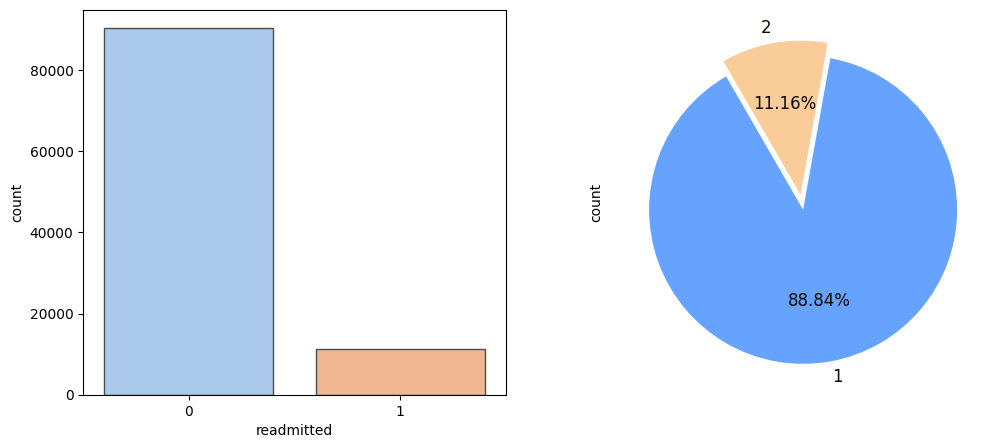

In [ ]:
fig, ax =plt.subplots(nrows=1,ncols=2, figsize=(12,5))
labels=['1','2']
sns.countplot(x=dataframe.readmitted, data=dataframe, palette="pastel",ax=ax[0], edgecolor=".3")
dataframe.readmitted.value_counts().plot.pie(autopct="%1.2f%%", ax=ax[1], colors=['#66a3ff','#facc99'],
                                        labels=labels, explode = (0.05, 0.05), startangle=120,
                                        textprops={'fontsize': 12, 'color':'#0a0a00'})
plt.show()

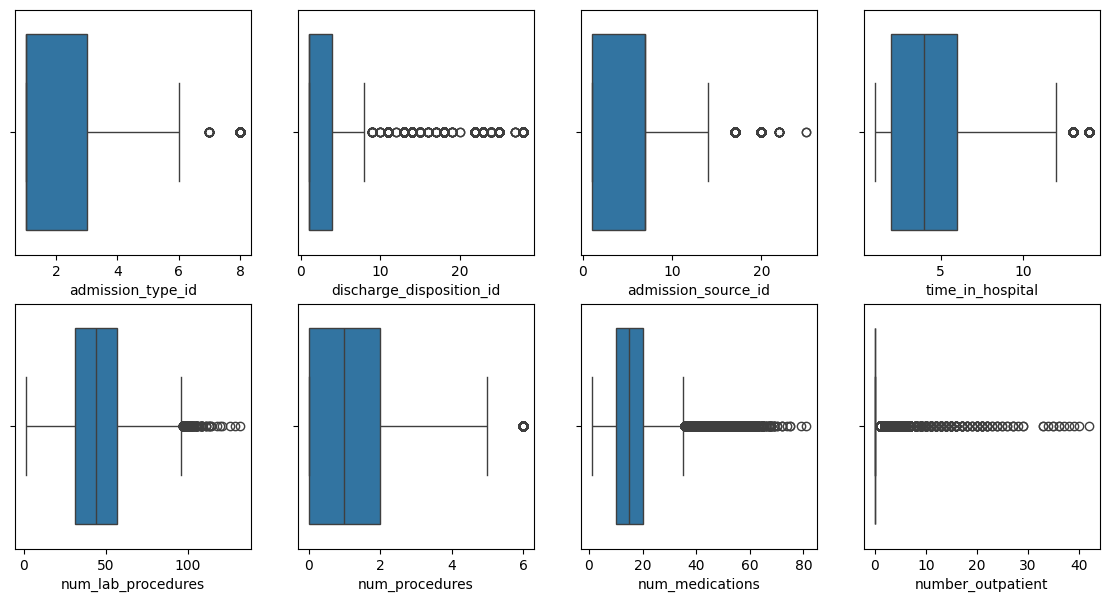

In [ ]:
def boxplot_for_outlier(df,columns):
    count = 0
    fig, ax =plt.subplots(nrows=2,ncols=4, figsize=(14,7))
    for i in range(2):
        for j in range(4):
            sns.boxplot(x = df[columns[count]], ax=ax[i][j])
            count = count+1

numeric_columns = dataframe.select_dtypes(include=['number']).columns
boxplot_for_outlier(dataframe, numeric_columns)

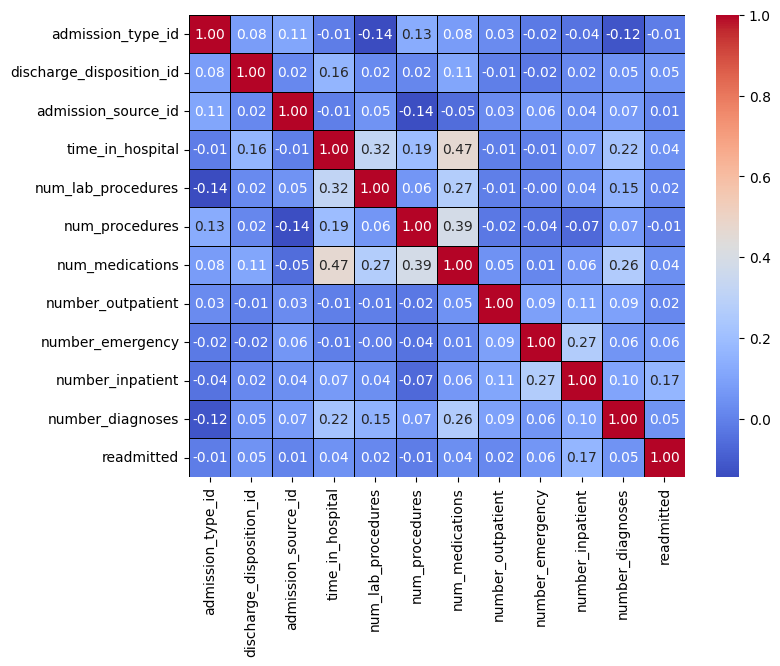

In [ ]:
f,ax = plt.subplots(figsize=(8, 6))
sns.heatmap(dataframe[numeric_columns].corr(), annot=True, linewidths=0.5, linecolor="black", fmt= '.2f', ax=ax, cmap="coolwarm")
plt.show()

<ipython-input-16-c9b4398715e3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe.gender, data=dataframe, palette="pastel", ax=ax[0], edgecolor=".3")


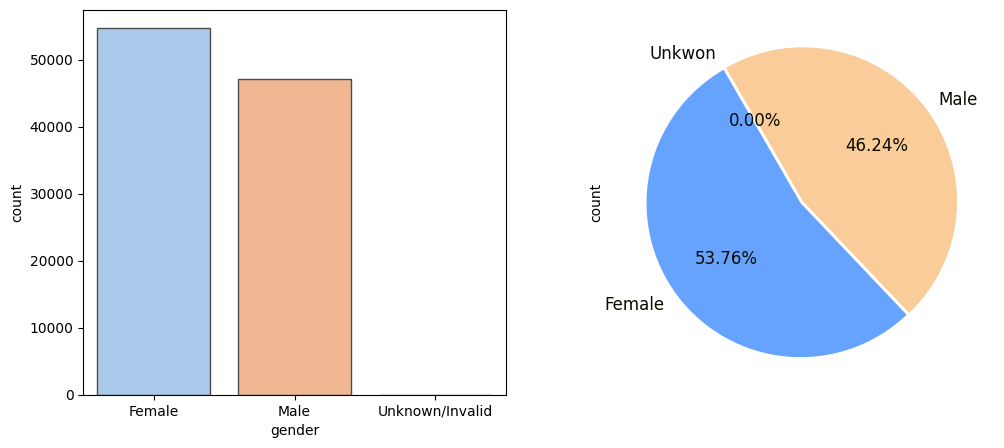

In [ ]:
fig, ax =plt.subplots(nrows=1,ncols=2, figsize=(12,5))
labels=['Female','Male', 'Unkwon']
sns.countplot(x=dataframe.gender, data=dataframe, palette="pastel", ax=ax[0], edgecolor=".3")
dataframe.gender.value_counts().plot.pie(autopct="%1.2f%%", ax=ax[1], colors=['#66a3ff','#facc99', '#90EE90'],
                                        labels=labels, explode = (0.01, 0.01, 0.01), startangle=120,
                                        textprops={'fontsize': 12, 'color':'#0a0a00'})
plt.show()

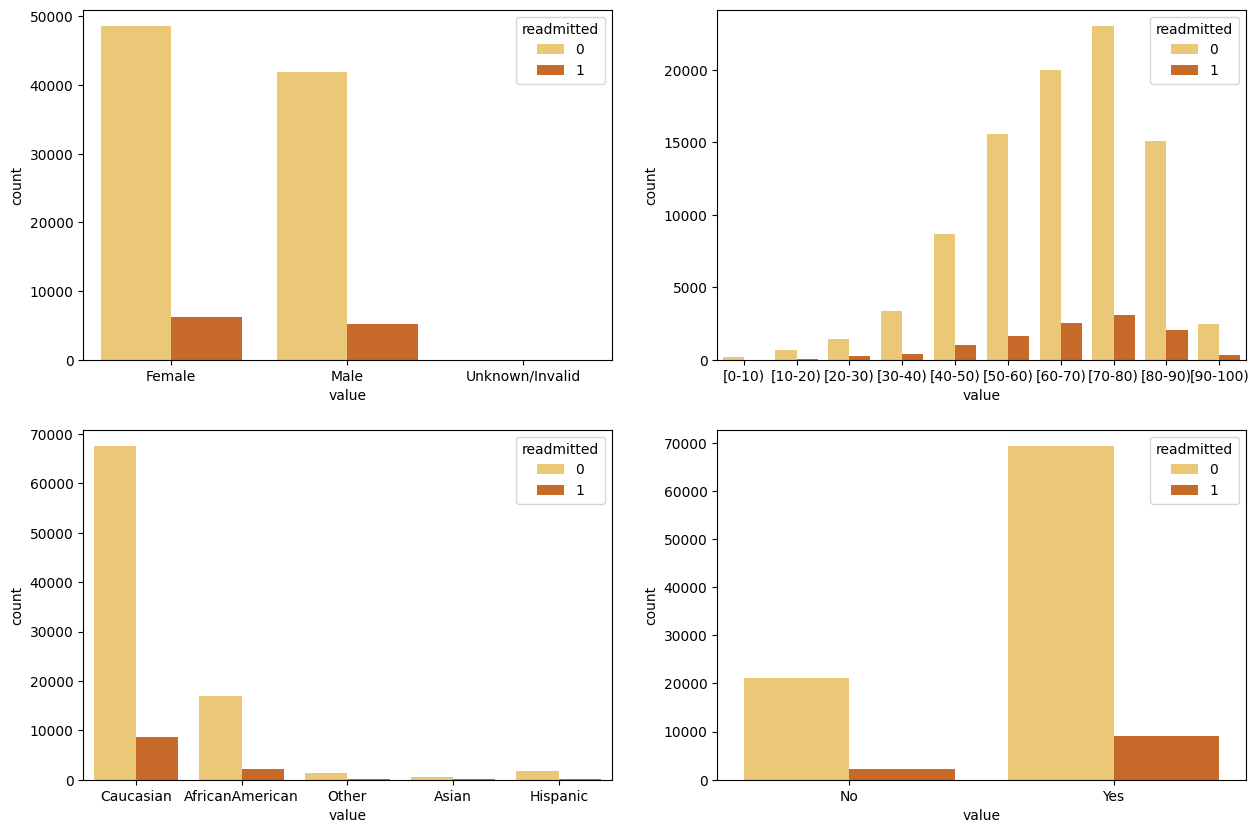

In [ ]:
visual_list = ['gender','age','race', 'diabetesMed']
fig, ax =plt.subplots(nrows=2,ncols=2,figsize=(15,10))
ax = ax.flatten()
count =0
for i in visual_list:
    melted_df = dataframe.melt(id_vars=['readmitted'], value_vars=[i], var_name='category', value_name='value')

    sns.countplot(x='value', hue='readmitted', data=melted_df, palette='YlOrBr', ax=ax[count]);
    count = count+1

# Data Engineering

### Baseline Dataset

##### converting target feature to 0 1

In [ ]:
base_df = dataframe.copy()

In [ ]:
base_df['readmitted'] = base_df['readmitted'].replace(['>30', 'NO'], 0)
base_df['readmitted'] = base_df['readmitted'].replace('<30', 1)

<ipython-input-345-8e77b875c04c>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_df['readmitted'] = base_df['readmitted'].replace('<30', 1)




---


##### removing columns
1. weight: 97% is missing
2. payer_code: 40% missing and irrelevant information
3. medical_specialty: 49% is missing. we have diagnoses features in the data, so knowing the specialty of the admitting physician will not help us. this feature also has 73 unique categorical values and grouping them is very time-consuming.

In [ ]:
drop_list = ['weight', 'payer_code', 'medical_specialty', 'citoglipton', 'examide']
base_df.drop(drop_list, axis=1, inplace=True)



---


##### handling missing values
1. Race: I'm filling NaN values in the race feature with 'No' because, based on my hypothesis, it seems like missing values actually mean the person is American and not part of a minority group. Meanwhile, 'Other' likely means they belong to a minority but aren't specifically identified. Of course, this is just an educated guess — I'm not a mind reader! But my analysis showed a real difference between 'Other' and NaN values when it comes to the 'readmitted' status, so maybe there's something going on here.

    Just to be clear, I'm not diving into why these differences exist across the race categories, I'm only analyzing and detecting these patterns to help the model make better predictions.
2. Gender: Dropping "Unknown/Invalid" because there are only three such values in this feature, and filling them wouldn't have any meaningful impact.

3. Max_glu_serum & A1Cresult: Replacing NaN values with "No" because missing values indicate that these tests were not measured.

4. Diag_1, Diag_2, Diag_3: Replacing NaN values with "No" since missing values in these features mean that the diagnosis was not recorded.

In [ ]:
base_df = base_df.query("gender != 'Unknown/Invalid'")
columns = ['race', 'diag_1', 'diag_2', 'diag_3', 'A1Cresult', 'max_glu_serum']
base_df[columns] = base_df[columns].replace(np.nan, 'No')
base_df = base_df.loc[~base_df.discharge_disposition_id.isin([10,11,19,20,21])]

<ipython-input-347-74cb9bf984ec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df[columns] = base_df[columns].replace(np.nan, 'No')


##### Base Data Encoding

In [ ]:
base_df['gender'] = base_df['gender'].replace({'Female': 1, 'Male': 0})
base_df['change'] = base_df['change'].replace({'Ch': 1, 'No': 0})
base_df['diabetesMed'] = base_df['diabetesMed'].replace({'Yes': 1, 'No': 0})
base_df[base_df.columns[19:42]] = base_df[base_df.columns[19:42]].replace(['No','Steady','Up','Down'],[0,1,1,1])

<ipython-input-348-0a170d1d4372>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_df['gender'] = base_df['gender'].replace({'Female': 1, 'Male': 0})
<ipython-input-348-0a170d1d4372>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_df['change'] = base_df['change'].replace({'Ch': 1, 'No': 0})
<ipython-input-348-0a170d1d4372>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to t

###### Diag Grouping

diag_1, diag_2, diag_3
grouping diagnoses based on their ICD9 code based on the link:
https://en.wikipedia.org/wiki/List_of_ICD-9_codes

In [ ]:
def transformFunc(value):
    value = re.sub("V[0-9]*", "0", value) # V
    value = re.sub("E[0-9]*", "-1", value) # E
    value = re.sub("No", "-2", value)
    return value

def transformCategory(value):
    if value>=390 and value<=459 or value==785:
        category = 'Circulatory'
    elif value>=460 and value<=519 or value==786:
        category = 'Respiratory'
    elif value>=520 and value<=579 or value==787:
        category = 'Digestive'
    elif value==250:
        category = 'Diabetes'
    elif value>=800 and value<=999:
        category = 'Injury'
    elif value>=710 and value<=739:
        category = 'Musculoskeletal'
    elif value>=580 and value<=629 or value==788:
        category = 'Genitourinary'
    elif value>=140 and value<=239 :
        category = 'Neoplasms'
    elif value==-1:
        category = 'NAN'
    else :
        category = 'Other'

    return category

In [ ]:
diag_list = ['diag_1','diag_2','diag_3']
for i in range(3):
    base_df[diag_list[i]] = base_df[diag_list[i]].apply(transformFunc).astype(float).apply(transformCategory)

In [ ]:
base_df['A1Cresult'] = base_df['A1Cresult'].replace(['>7','>8','Norm','No'],[1,2,0,-99])
base_df['max_glu_serum'] = base_df['max_glu_serum'].replace(['>200','>300','Norm','No'],[1,2,0,-99])

<ipython-input-351-c8776628bf70>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_df['A1Cresult'] = base_df['A1Cresult'].replace(['>7','>8','Norm','No'],[1,2,0,-99])
<ipython-input-351-c8776628bf70>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_df['max_glu_serum'] = base_df['max_glu_serum'].replace(['>200','>300','Norm','No'],[1,2,0,-99])


##### wandb

In [ ]:
def wandb_dataset(df, df_name):
    run = wandb.init(project="midterm", name=f"{df_name}_dataset",
                 notes=f"Create the {df_name} dataset")

    filename = f"{df_name}_data.csv"
    df.to_csv(filename, index=False)

    artifact = wandb.Artifact(f"{df_name}_dataset", type="dataset", description=f"Fixed {df_name} set")
    artifact.add_file(filename)
    run.log_artifact(artifact)

    run.finish()

In [ ]:
wandb_dataset(base_df, 'baseline')

### Dataset With Feature Mapping



---


##### mapping feature values
mapping and grouping values of the next features:


*   admission_type_id
*   discharge_disposition_id
*   admission_source_id
*   diag_1, diag_2, diag_3






converting admissions to 3 types:
1. emergency/urgent
2. trauma
3. elective
4. NAN

In [ ]:
add_type_mapping = {
    **dict.fromkeys([1, 2], "urgent"),
    **dict.fromkeys([7], "trauma"),
    **dict.fromkeys([3], "elective")
}

In [ ]:
def admission_mapping(df):
    df['admission_type_id'] = df['admission_type_id'].apply(lambda x: add_type_mapping.get(x, "NAN"))

discharge_disposition_id






converting discharge_disposition_id to next types:
*   none
*   died/hospice
*   discharged
*   transferred
*   inpatient

In [ ]:
discharg_mapping = {
    **dict.fromkeys([13, 14], "hospice"),
    **dict.fromkeys([9, 15], "inpatient"),
    **dict.fromkeys([1, 16, 17, 23, 25, 27, 30], "discharged"),
    **dict.fromkeys([2, 3, 4, 6, 7, 8, 10, 24], "transferred"),
    **dict.fromkeys([5, 22, 29], "transfered_inpatient"),
    **dict.fromkeys([28], "psychiatric")
}

In [ ]:
def discharge_disposition_mapping(df):
    df['discharge_disposition_id'] = df['discharge_disposition_id'].apply(lambda x: discharg_mapping.get(x, "NAN"))

converting admission_source_id to next types:
* none
* referrals
* transfers
* birth-related
* emergency

In [ ]:
ad_source_mapping = {
    **dict.fromkeys([1, 2, 3], "referrals"),
    **dict.fromkeys([4, 5, 6, 8, 18, 19, 22, 25], "transfers"),
    **dict.fromkeys([11, 12, 13, 14, 23, 24], "birth-related"),
    **dict.fromkeys([7, 25], "emergency")
}

In [ ]:
def admission_source_mapping(df):
    df['admission_source_id'] = df['admission_source_id'].apply(lambda x: ad_source_mapping.get(x, "NAN"))

In [ ]:
mapped_df = base_df.copy()
admission_mapping(mapped_df)
discharge_disposition_mapping(mapped_df)
admission_source_mapping(mapped_df)

In [ ]:
wandb_dataset(mapped_df, 'mapped')

# Data Preprocessing

### Removing values

In [ ]:
def remover(df, columns):
    df.drop(columns, axis=1, inplace=True)

### Encoding

In [ ]:
def one_hot_encoder(df, columns, drop=None):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop=drop)
    encoded_features = encoder.fit_transform(df[columns])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(columns), index=df.index)

    df = pd.concat([df.drop(columns, axis=1), encoded_df], axis=1)
    return df, encoder

### Scaling

In [ ]:
def satndartd_scaler(df):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_features, columns=df.columns, index=df.index)
    return scaled_df, scaler

def min_max_scaler(df):
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_features, columns=df.columns, index=df.index)
    return scaled_df, scaler

### Sampling

In [ ]:
def sampler(X_train, y_train):
    X = pd.concat([X_train, y_train], axis=1)

    not_readmitted = X[X.readmitted==0]
    readmitted = X[X.readmitted==1]

    not_readmitted_sampled = resample(not_readmitted,
                                    replace = False,
                                    n_samples = len(readmitted),
                                    random_state = 42)

    downsampled = pd.concat([not_readmitted_sampled, readmitted])

    print(downsampled.readmitted.value_counts())
    y_train = downsampled.readmitted
    X_train = downsampled.drop('readmitted', axis=1)
    return X_train, y_train

# Model Selection

### Scoring Functions

In [ ]:
def calc_specificity(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    fscore = f1_score(y_actual,(y_pred > thresh) )
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('fscore:%.3f'%fscore)
    print('specificity:%.3f'%specificity)
    print(' ')
    return auc, accuracy, recall, precision,fscore, specificity

### Baseline Models

In [ ]:
baseline_models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': XGBClassifier(),
    'Light-GBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(),
    'CatBoost': CatBoostClassifier()
}

### Run Models

In [ ]:
def run_models(models, X_train, y_train, X_test, y_test):
    for model_name, model in baseline_models.items():
        print(f"Running {model_name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print_report(y_test, y_pred, 0.5)

### Data Processor

In [ ]:
def processor(data):
    df = pd.read_csv(data)
    df, _ = one_hot_encoder(df, one_hot_columns, drop=None)

    X = df.drop(columns="readmitted", axis=1)
    Y = df.readmitted

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

    ordinal_enc = OrdinalEncoder()
    X_train.age = ordinal_enc.fit_transform(X_train.age.values.reshape(-1, 1))
    X_test.age = ordinal_enc.transform(X_test.age.values.reshape(-1, 1))

    X_train, y_train = sampler(X_train, y_train)
    return X_train, y_train, X_test, y_test

### Running Baseline Models On Each Dataset

In [ ]:
datasets = ["baseline_dataset", "mapped_dataset"]
one_hot_columns = ['race', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2', 'diag_3']
for dataset_name in datasets:
    print(f"Running {dataset_name}...")

    run = wandb.init(project="midterm",
                     name=f"train_model_with_{dataset_name}",
                     notes=f"Training models using {dataset_name}")

    data = wandb.use_artifact(f"midterm/{dataset_name}:latest").file()

    X_train, y_train, X_test, y_test = processor(data)

    run_models(baseline_models, X_train, y_train, X_test, y_test)

    run.finish()

Running baseline_dataset...
readmitted
0    8987
1    8987
Name: count, dtype: int64
Running Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC:0.605
accuracy:0.632
recall:0.568
precision:0.175
fscore:0.268
specificity:0.641
 
Running Decision Tree...
AUC:0.555
accuracy:0.551
recall:0.561
precision:0.143
fscore:0.228
specificity:0.550
 
Running Random Forest...
AUC:0.614
accuracy:0.627
recall:0.596
precision:0.178
fscore:0.275
specificity:0.632
 
Running Gradient Boosting...
AUC:0.611
accuracy:0.621
recall:0.597
precision:0.176
fscore:0.272
specificity:0.624
 
Running K-Nearest Neighbors...
AUC:0.608
accuracy:0.617
recall:0.596
precision:0.174
fscore:0.269
specificity:0.620
 
Running Light-GBM...
[LightGBM] [Info] Number of positive: 8987, number of negative: 8987
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 17974, number of used features: 91
[LightGBM] [I

Running mapped_dataset...


readmitted
0    8987
1    8987
Name: count, dtype: int64
Running Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC:0.608
accuracy:0.639
recall:0.566
precision:0.178
fscore:0.271
specificity:0.649
 
Running Decision Tree...
AUC:0.552
accuracy:0.551
recall:0.553
precision:0.142
fscore:0.226
specificity:0.551
 
Running Random Forest...
AUC:0.607
accuracy:0.624
recall:0.585
precision:0.175
fscore:0.269
specificity:0.630
 
Running Gradient Boosting...
AUC:0.613
accuracy:0.623
recall:0.601
precision:0.177
fscore:0.274
specificity:0.626
 
Running K-Nearest Neighbors...
AUC:0.597
accuracy:0.605
recall:0.587
precision:0.167
fscore:0.260
specificity:0.608
 
Running Light-GBM...
[LightGBM] [Info] Number of positive: 8987, number of negative: 8987
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 17974, number of used features: 74
[LightGBM] [I

### Hyperparameter Tuning

In [ ]:
best_dataset = "mapped_dataset"
best_models = {
    'Random Forest': [RandomForestClassifier(),
                      {"max_depth": [2,5,8],
                        "n_estimators": [100,200,500,700],
                        "max_features": [3,5,8],
                        "min_samples_split":[2,5,10]}
                      ],
    'Light-GBM': [LGBMClassifier(),
                {"learning_rate":[0.01,0.1,0.05],
                "n_estimators": [100,200,500],
                "subsample":[0.1,0.2],
                "max_depth":[2,3,5,8]}
                  ],
    'CatBoost': [CatBoostClassifier(),
                {"iterations":[200,500,1000],
                "learning_rate":[0.05,0.1],
                "depth":[4,5,8]}
                 ]
}

In [ ]:
for model_name, model in best_models.items():

    run = wandb.init(project="midterm",
                     name=f"hypertuning_{model_name}_with_{best_dataset}",
                     notes=f"hypertuning {model_name} using {best_dataset}")

    print(f"Running {model_name}...")

    data = wandb.use_artifact(f"midterm/{best_dataset}:latest").file()

    X_train, y_train, X_test, y_test = processor(data)

    run_models(models, X_train, y_train, X_test, y_test)

    print(cv_model.best_params_)

    run.finish()

Running Random Forest...
readmitted
0    8987
1    8987
Name: count, dtype: int64
Fitting 3 folds for each of 108 candidates, totalling 324 fits
{'max_depth': 8, 'max_features': 5, 'min_samples_split': 10, 'n_estimators': 500}


Running Light-GBM...
readmitted
0    8987
1    8987
Name: count, dtype: int64
Fitting 3 folds for each of 72 candidates, totalling 216 fits
[LightGBM] [Info] Number of positive: 8987, number of negative: 8987
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 17974, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Running CatBoost...
readmitted
0    8987
1    8987
Name: count, dtype: int64
Fitting 3 folds for each of 18 candidates, totalling 54 fits
0:	learn: 0.6898345	total: 6.97ms	remaining: 1.39s
1:	learn: 0.6864201	total: 12.7ms	remaining: 1.26s
2:	learn: 0.6835777	total: 19.2ms	remaining: 1.26s
3:	learn: 0.6807302	total: 25.2ms	remaining: 1.24s
4:	learn: 0.6785914	total: 31.2ms	remaining: 1.22s
5:	learn: 0.6762220	total: 36.8ms	remaining: 1.19s
6:	learn: 0.6743280	total: 42.6ms	remaining: 1.17s
7:	learn: 0.6726788	total: 48.7ms	remaining: 1.17s
8:	learn: 0.6711389	total: 54.8ms	remaining: 1.16s
9:	learn: 0.6697066	total: 60.6ms	remaining: 1.15s
10:	learn: 0.6682666	total: 67ms	remaining: 1.15s
11:	learn: 0.6671124	total: 72.8ms	remaining: 1.14s
12:	learn: 0.6659705	total: 78.8ms	remaining: 1.13s
13:	learn: 0.6648544	total: 84.6ms	remaining: 1.12s
14:	learn: 0.6637731	total: 90.5ms	remaining: 1.12s
15:	learn: 0.6628865	total: 96.9ms	remaining: 1.11s
16:	learn: 0.6620343	total: 103ms	remainin

### Best Models With Best Parameters

In [ ]:
best_models_with_best_params = {
    'Random Forest': RandomForestClassifier(max_depth=8, max_features=5, min_samples_split=10, n_estimators=500),
    'Light-GBM': LGBMClassifier(learning_rate=0.1, max_depth=2, n_estimators=200, subsample=0.1),
    'CatBoost': CatBoostClassifier(depth=5, iterations=200, learning_rate=0.05),
}

In [ ]:
trained_models = {}
run = wandb.init(project="midterm",
                name=f"testing_{model_name}_with_best_params",
                notes=f"testing {model_name} using best parameters")

print(f"Running {model_name}...")

data = wandb.use_artifact(f"midterm/{best_dataset}:latest").file()

X_train, y_train, X_test, y_test = processor(data)

for model_name, model in best_models_with_best_params.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print_report(y_test, y_pred, 0.5)
    trained_models[model_name] = model

run.finish()

Running CatBoost...
readmitted
0    8987
1    8987
Name: count, dtype: int64
AUC:0.615
accuracy:0.601
recall:0.634
precision:0.174
fscore:0.273
specificity:0.597
 


[LightGBM] [Info] Number of positive: 8987, number of negative: 8987
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 17974, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

### Feature Importance

Model: Random Forest...
                                          Feature  Importance
8                                number_inpatient    0.219852
46            discharge_disposition_id_discharged    0.089834
50  discharge_disposition_id_transfered_inpatient    0.068810
5                                 num_medications    0.055561
7                                number_emergency    0.050037
..                                            ...         ...
53              admission_source_id_birth-related    0.000000
25                                   troglitazone    0.000000
30                       glimepiride-pioglitazone    0.000000
31                        metformin-rosiglitazone    0.000000
32                         metformin-pioglitazone    0.000000

[87 rows x 2 columns]


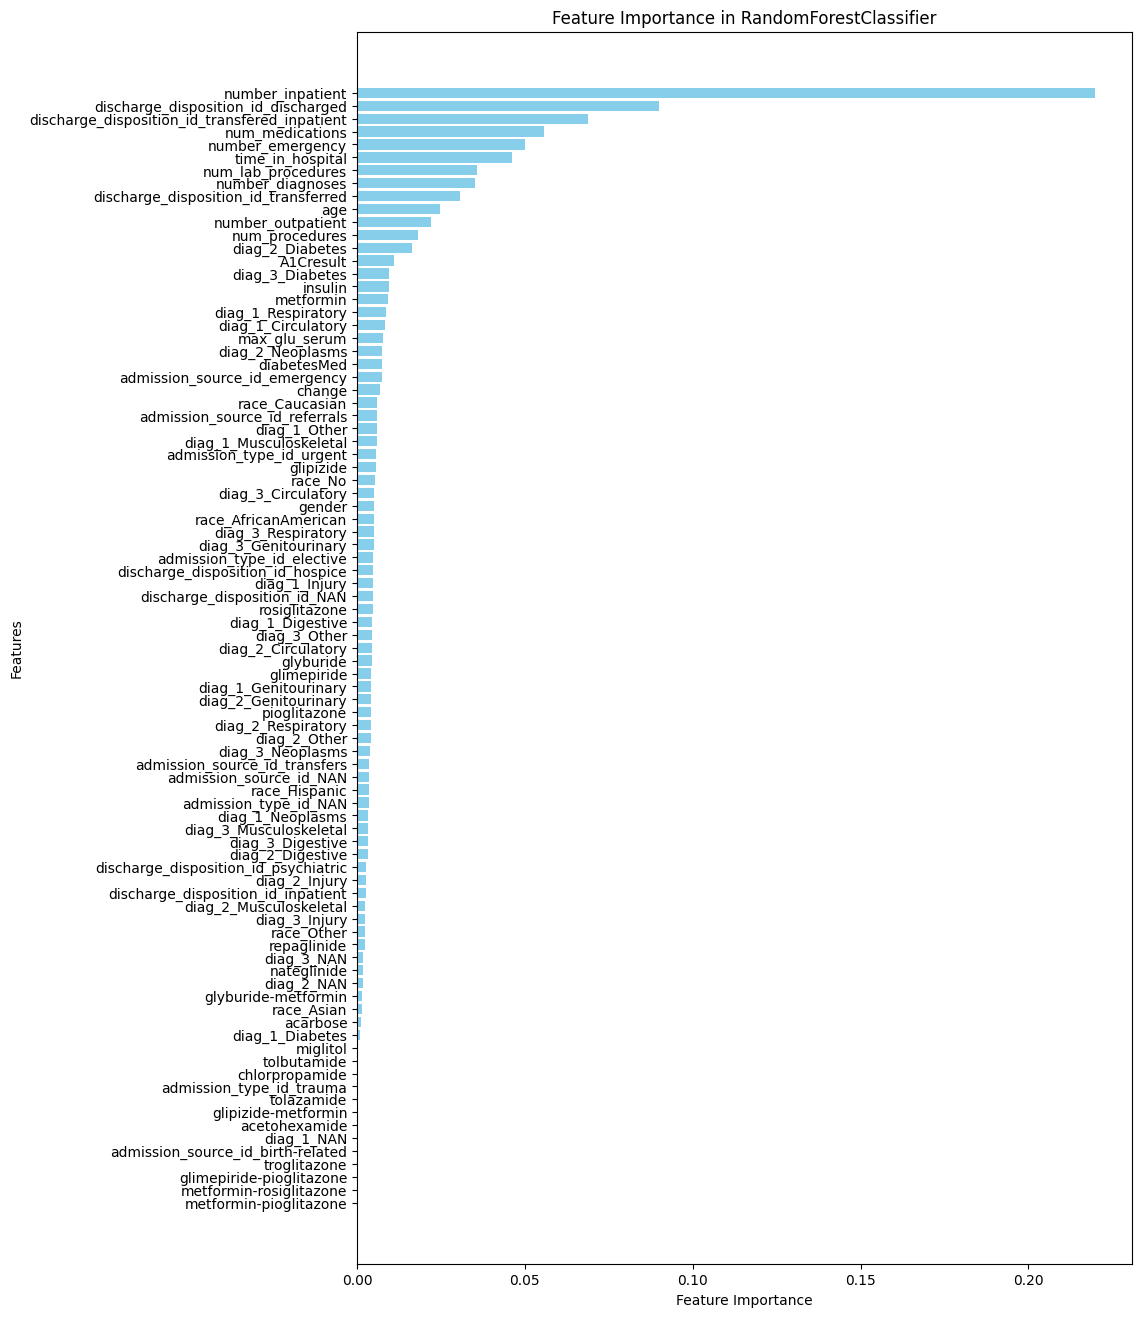

Model: Light-GBM...
                                          Feature  Importance
8                                number_inpatient          60
5                                 num_medications          55
3                              num_lab_procedures          39
50  discharge_disposition_id_transfered_inpatient          27
1                                             age          26
..                                            ...         ...
61                                  diag_1_Injury           0
29                            glipizide-metformin           0
63                                     diag_1_NAN           0
64                               diag_1_Neoplasms           0
43                       admission_type_id_trauma           0

[87 rows x 2 columns]


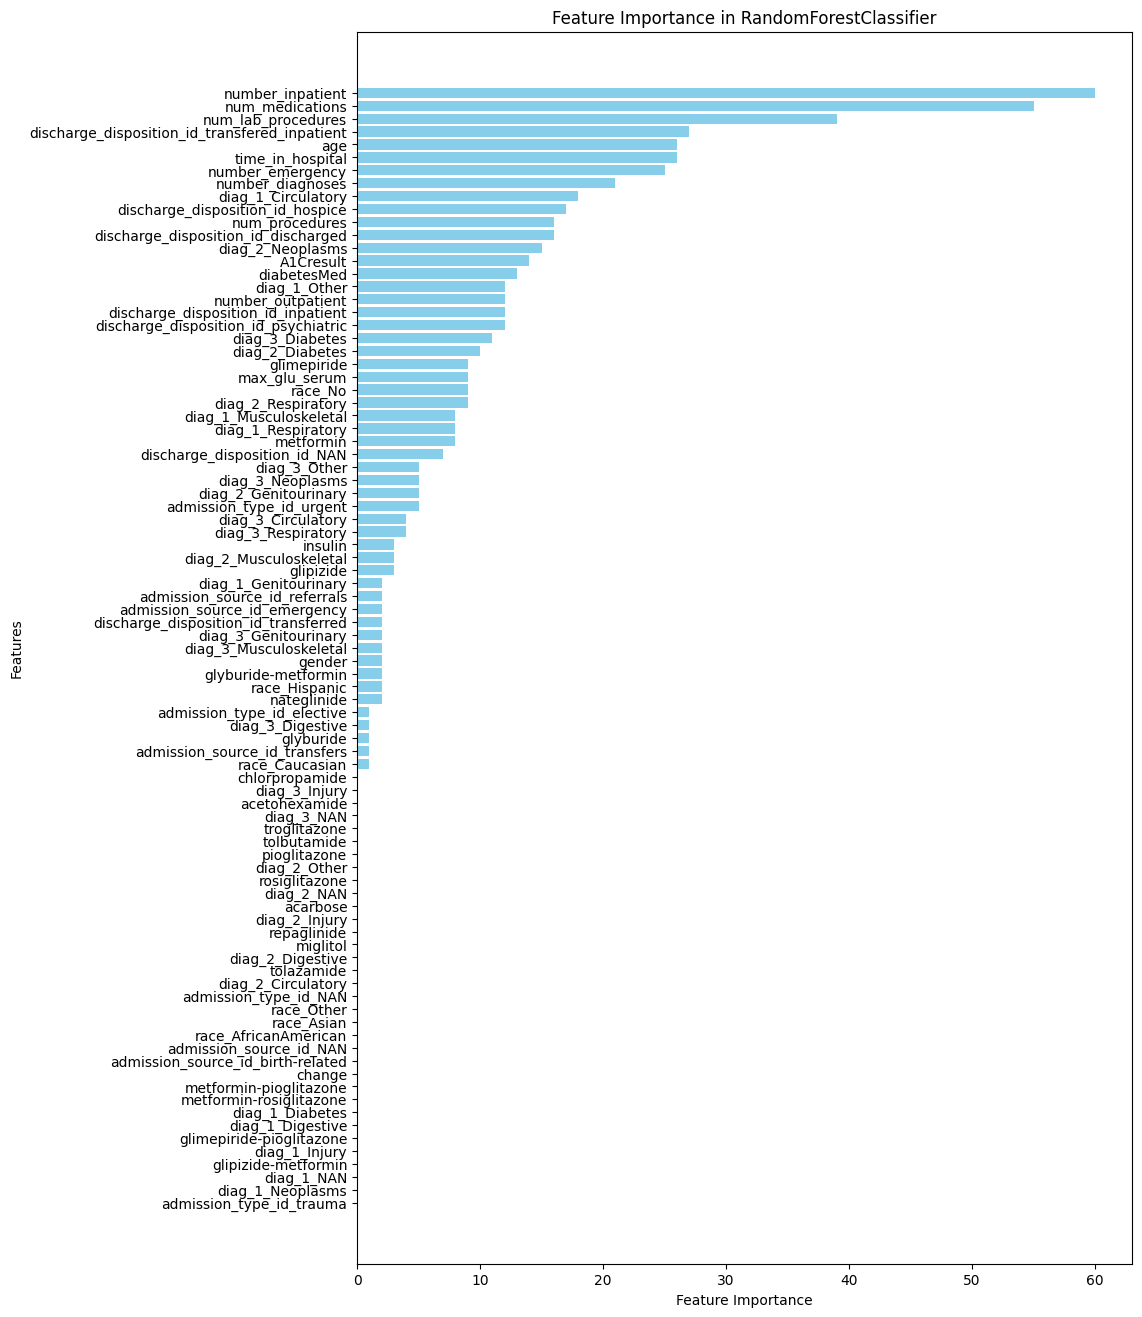

Model: CatBoost...
                                          Feature  Importance
8                                number_inpatient   27.889964
46            discharge_disposition_id_discharged    9.353915
50  discharge_disposition_id_transfered_inpatient    8.406499
5                                 num_medications    4.894923
2                                time_in_hospital    4.148426
..                                            ...         ...
32                         metformin-pioglitazone    0.000000
83                                     diag_3_NAN    0.000000
13                                    repaglinide    0.000000
63                                     diag_1_NAN    0.000000
53              admission_source_id_birth-related    0.000000

[87 rows x 2 columns]


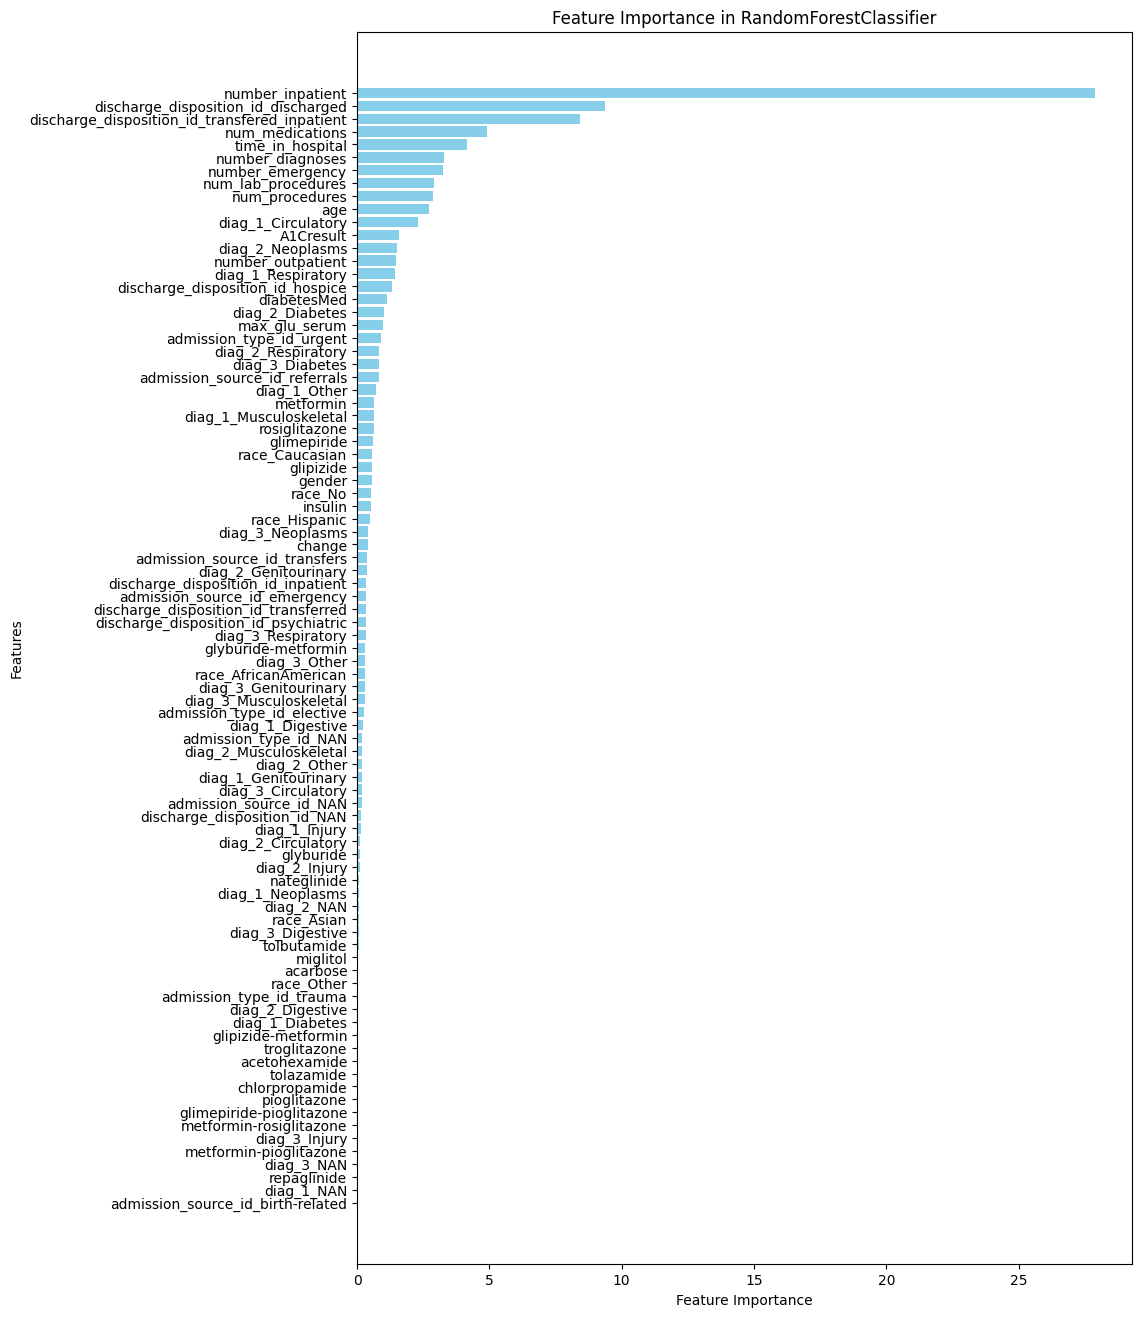

In [ ]:
best_features = []
for model_name, model in trained_models.items():
    print(f"Model: {model_name}...")
    feature_importances = model.feature_importances_
    feature_names = X_train.columns

    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by="Importance", ascending=False)

    feature_imp = pd.Series(model.feature_importances_, index=X_train.columns)
    best_features.extend(feature_imp.nlargest(25).index)

    print(importance_df)

    plt.figure(figsize=(10, 16))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.title("Feature Importance in RandomForestClassifier")
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
best_features = list(set(best_features))

### Training Models With The Most Important Features

In [ ]:
run = wandb.init(project="midterm",
                name=f"training_{model_name}_with_best_features",
                notes=f"training {model_name} using best features")

data = wandb.use_artifact(f"midterm/{best_dataset}:latest").file()

X_train, y_train, X_test, y_test = processor(data)

for model_name, model in best_models_with_best_params.items():
    print(f"Running {model_name}...")
    model.fit(X_train[best_features], y_train)
    y_pred = model.predict(X_test[best_features])
    print_report(y_test, y_pred, 0.5)
    trained_models[model_name] = model

run.finish()

readmitted
0    8987
1    8987
Name: count, dtype: int64
Running Random Forest...
AUC:0.613
accuracy:0.599
recall:0.630
precision:0.173
fscore:0.271
specificity:0.595
 
Running Light-GBM...
[LightGBM] [Info] Number of positive: 8987, number of negative: 8987
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 17974, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

# Selecting & Saving The Best Model

In [544]:
model = RandomForestClassifier(max_depth=8, max_features=5, min_samples_split=10, n_estimators=500)
model.fit(X_train[best_features], y_train)
y_pred = model.predict(X_test[best_features])
print_report(y_test, y_pred, 0.5)

AUC:0.617
accuracy:0.597
recall:0.643
precision:0.174
fscore:0.274
specificity:0.591
 


(0.6168720075863788,
 0.5972229159382648,
 0.6426160337552742,
 0.1742562929061785,
 0.27416741674167416,
 0.5911279814174835)

In [545]:
wandb.init(project="midterm", name="random_forest_model")
joblib.dump(model, "random_forest_model.pkl")
artifact = wandb.Artifact("random_forest", type="model")
artifact.add_file("random_forest_model.pkl")
wandb.log_artifact(artifact)
wandb.finish()

# nn

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def build_model(input_shape):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
X_train_nn, X_test_nn = X_train[best_features], X_test[best_features]
# X_train_nn, X_test_nn = X_train, X_test
model = build_model(X_train_nn.shape[1])
model.fit(X_train_nn, y_train, epochs=20, batch_size=128, validation_data=(X_test_nn, y_test))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4960 - loss: 2.4057 - val_accuracy: 0.3558 - val_loss: 0.7804
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5166 - loss: 0.7887 - val_accuracy: 0.4471 - val_loss: 0.6897
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5136 - loss: 0.7217 - val_accuracy: 0.6508 - val_loss: 0.6601
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5302 - loss: 0.7030 - val_accuracy: 0.5858 - val_loss: 0.6836
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5486 - loss: 0.6903 - val_accuracy: 0.5589 - val_loss: 0.6852
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5604 - loss: 0.6858 - val_accuracy: 0.5636 - val_loss: 0.6841
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5785 - loss: 0.6789 - val_accuracy: 0.4738 - val_loss: 0.7182
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5828 - loss: 0.6721 - val_accuracy: 0.5527 - val

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.5964
Precision: 0.7081
Recall: 0.3279
F1 Score: 0.4482


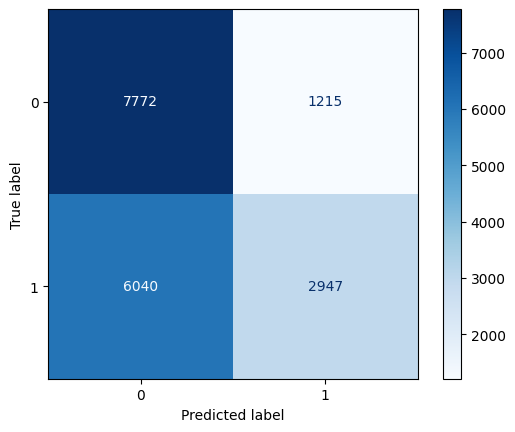

626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.7922
Precision: 0.2274
Recall: 0.3152
F1 Score: 0.2642


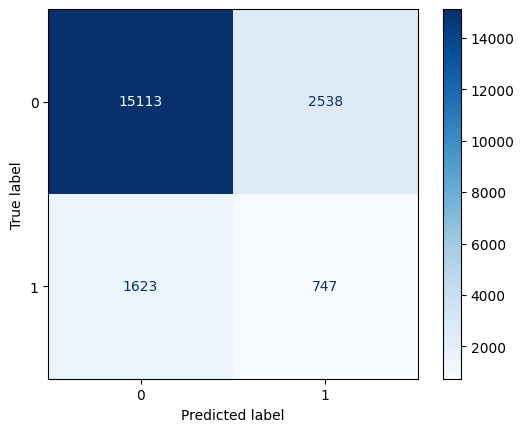

In [ ]:
evaluate_model(model, X_train_nn, y_train)
evaluate_model(model, X_test_nn, y_test)